In [333]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor


import yfinance as yf

import talib
import seaborn as sns
import plotly.graph_objects as go

In [334]:
tickerStrings = ['v']
for ticker in tickerStrings:
    data = yf.download(ticker, group_by="Ticker", end='2019-01-01',start='2014-01-01')
    data['ticker'] = ticker 
    data.to_csv(f'ticker_{ticker}.csv') 
    

[*********************100%***********************]  1 of 1 completed


In [335]:
from pathlib import Path

# set the path to the files
p = Path(r"C:\Users\Dan\Desktop\python code\Data")

# find the files
files = list(p.glob('ticker_*.csv'))

# read the files into a dataframe
df_list = list()
for file in files:
    df_list.append(pd.read_csv(file))

# combine dataframes
df = pd.concat(df_list)

In [336]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'ticker'],
      dtype='object')

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.123648
5d_close_future_pct     -0.123648             1.000000


[]

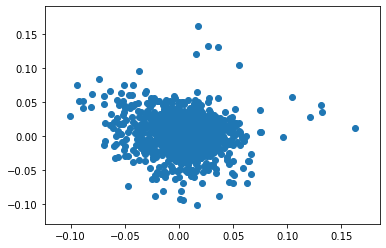

In [337]:
#create 5d % change and 5day in future
df['5d_future_close']=df['Adj Close'].shift(-5)
df['5d_close_future_pct']=df['5d_future_close'].pct_change(5)
df['5d_close_pct']=df['Adj Close'].pct_change(5)

corr= df[['5d_close_pct','5d_close_future_pct']].corr()
print(corr)

plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.plot()

In [338]:
feature_names = ['5d_close_pct']  # list of features, save for later

# createing moving averages and rsi for 14, 30, 50 200 days
for n in [14, 30, 50, 200]:

    #  moving average indicator 
    df['ma' + str(n)] = talib.SMA(df['Adj Close'].values,
                              timeperiod=n) / df['Adj Close']
    # rsi indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [339]:
# dropping na
df = df.dropna()

# create features and targets

features = df[feature_names]
targets = df['5d_close_future_pct']

# for columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.109494  0.110020 -0.126267   
5d_close_pct                   -0.109494      1.000000 -0.845625  0.628960   
ma14                            0.110020     -0.845625  1.000000 -0.811241   
rsi14                          -0.126267      0.628960 -0.811241  1.000000   
ma30                            0.111151     -0.651123  0.864824 -0.911764   
rsi30                          -0.140334      0.478644 -0.656418  0.936676   
ma50                            0.131434     -0.517768  0.712915 -0.892615   
rsi50                          -0.140586      0.389845 -0.549058  0.845717   
ma200                           0.179138     -0.300933  0.426980 -0.629008   
rsi200                         -0.152431      0.182205 -0.272109  0.504564   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.111151 -0.140334  0.131434 -0.140586  0.17913

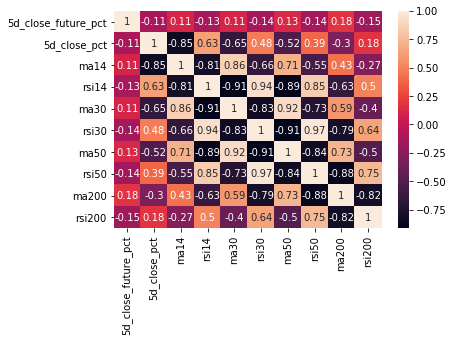

In [340]:
# heat map for correlation
sns.heatmap(corr, annot=True )
plt.yticks(rotation=0 )
plt.xticks(rotation=90)  
plt.show()

In [342]:
#add constant for linear model
linear_features = sm.add_constant(features)

# training on 80% of data
train_size = int(0.80 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1053, 10) (842, 10) (211, 10)


In [343]:
# save to use in tensorflow vir env
test_features.to_csv('test_features for tensorflow.csv')
test_targets.to_csv('test_targets for tensorflow.csv')
train_features.to_csv('train_features for tensorflow.csv')
train_targets.to_csv('train_targets for tensorflow.csv')

In [344]:
# linear model with OLS
model = sm.OLS(train_targets, train_features)
results = model.fit() 
print(results.summary())

# examine pvalues to see signficance

print(results.pvalues)

# Make predictions on model
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.110
Model:                             OLS   Adj. R-squared:                  0.100
Method:                  Least Squares   F-statistic:                     11.38
Date:                 Mon, 07 Dec 2020   Prob (F-statistic):           6.34e-17
Time:                         22:02:33   Log-Likelihood:                 1942.8
No. Observations:                  842   AIC:                            -3866.
Df Residuals:                      832   BIC:                            -3818.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0826      0.118    

In [345]:
#my face it's colored in shock as technical indicators show correlation

[]

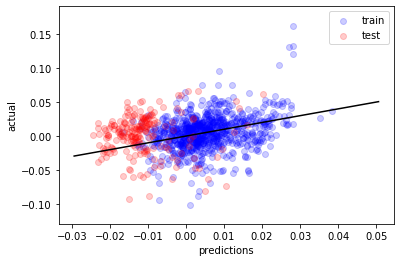

In [346]:
# scatter plot of train vs test predictions
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions,test_targets,alpha=0.2, color='r', label='test')


xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')


plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  
plt.plot()

[]

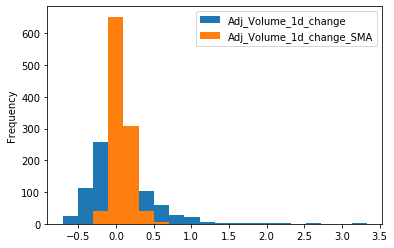

In [347]:
# add volume features, 1-day % change & 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
df['Adj_Volume_1d_change'] = df['Volume'].pct_change()
df['Adj_Volume_1d_change_SMA'] = talib.SMA(df['Adj_Volume_1d_change'].values,
                                               timeperiod=5)

# Plot histogram of volume % change data
df[new_features].plot(kind='hist', sharex=False, bins=20)
plt.plot()

In [348]:
#reclassify date col
date_=df['Date'].astype('datetime64[ns]')

In [349]:
#  get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(date_.dt.dayofweek,
                              prefix='weekday',
                              drop_first=True)
                              
# set index same to concat
days_of_week.index = df.index

df = pd.concat([df, days_of_week], axis=1)

# adding days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 6)])
df.dropna(inplace=True)  # drop missing values in-place
print(df.head())

           Date       Open       High        Low      Close  Adj Close  \
205  2014-10-24  53.407501  53.537498  52.965000  53.369999  51.033009   
206  2014-10-27  53.264999  53.682499  53.052502  53.352501  51.016277   
207  2014-10-28  53.652500  54.215000  53.514999  54.177502  51.805153   
208  2014-10-29  54.077499  54.599998  53.437500  53.665001  51.315098   
209  2014-10-30  57.132500  59.820000  57.005001  59.162498  56.571857   

       Volume ticker  5d_future_close  5d_close_future_pct  ...      ma50  \
205  10896000      v        57.714542             0.130926  ...  0.994860   
206   6658800      v        57.740837             0.131812  ...  0.995488   
207  10497600      v        58.082672             0.121176  ...  0.980549   
208  16095200      v        59.650860             0.162443  ...  0.989882   
209  50857600      v        59.784733             0.056793  ...  0.899628   

         rsi50     ma200     rsi200  Adj_Volume_1d_change  \
205  50.697706  1.002704  49.20

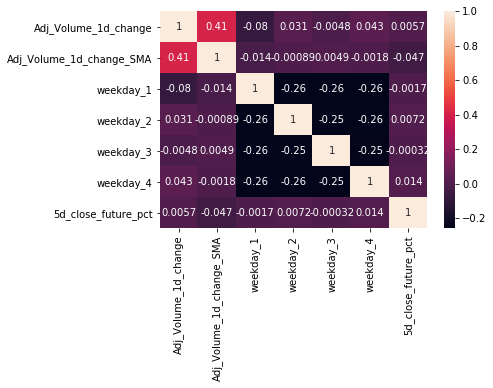

In [350]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical

plt.show()

In [351]:
#DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()

np.random.seed(11)
decision_tree.fit(train_features,train_targets)

# Check the score on train and test
print('train score', decision_tree.score(train_features, train_targets))
print('test score' , decision_tree.score(test_features,test_targets))

train score 0.9999895496484057
test score -1.087022744589051


In [352]:
# Loopind through to change max depth
np.random.seed(11)
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # score print
    print('max_depth=', str(d))
    print('train score', decision_tree.score(train_features, train_targets))
    print('test score' , decision_tree.score(test_features,test_targets))

max_depth= 3
train score 0.23804021215218277
test score -0.021024218644622783
max_depth= 5
train score 0.32842334772351467
test score 0.011291384967806462
max_depth= 10
train score 0.48418531483625005
test score -0.22799259856267362


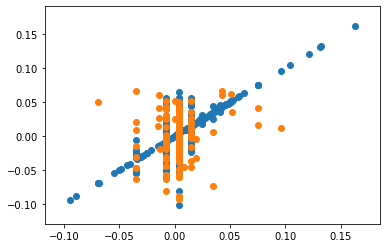

In [353]:
# using best max depth
np.random.seed(11)
decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

#scatter pred v actual
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

In [354]:
#random forest model
np.random.seed(11)
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features,train_targets)

# r2
print('R^2 for training data', rfr.score(train_features, train_targets))
print('R^2 for test data',rfr.score(test_features, test_targets))


R^2 for training data 0.9161325052977781
R^2 for test data -0.13841427540297446


In [355]:
# dict for hyper param
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [11]}
test_scores = []

# Loop for param
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # unpack dict
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# find best hyperparameters from test
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.02157159584134949 {'random_state': 11, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


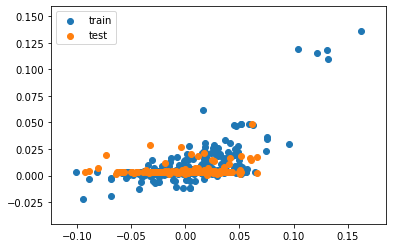

In [356]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=8, random_state=11)
rfr.fit(train_features, train_targets)

# make predictions 
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

In [358]:
#replot with go fig
fig = go.Figure()


fig.add_trace(go.Scatter(x=train_targets, y=train_predictions, name='train', mode='markers', marker_color='rgba(152, 0, 0, .8)'))
fig.add_trace(go.Scatter(x=test_targets, y=test_predictions, name='test', mode='markers', marker_color='rgba(0, 152, 0, .8)'))

fig.update_layout(title = f' data viz',title_x=0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()

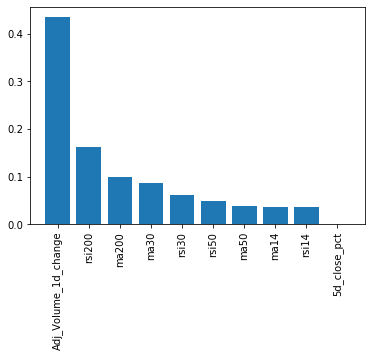

In [359]:
# get feature importance from rfr
importances = rfr.feature_importances_

sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
#plot for feat importance 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [360]:
#gradient boosting
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features,train_targets)

print('train score for gradient booster:', gbr.score(train_features, train_targets))
print('test score for gradient booster:', gbr.score(test_features, test_targets))

train score for gradient booster: 0.32180011481082826
test score for gradient booster: 0.0031949472085754937


In [325]:
#ouch

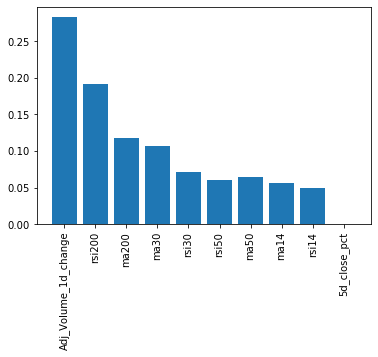

In [361]:
# feature importances from  gbr
gbr_importances = gbr.feature_importances_

# create plot again
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))


labels = np.array(feature_names)[sorted_index]
plt.bar(x, gbr_importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [362]:
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200', 'Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']


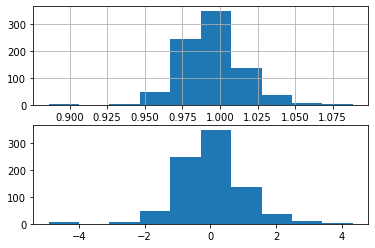

In [363]:
# Removing weekdays for knn
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# histogram plot of the 14-day SMA RSI before & after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [364]:
#knn
np.random.seed(11)
for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)  
    knn.fit(scaled_train_features, train_targets)
    
    print("n_neighbors =", n)
    print('train score', knn.score(scaled_train_features, train_targets))
    print('test score', knn.score(scaled_test_features, test_targets))
    print()#line break

n_neighbors = 2
train score 0.6436607100785992
test score -0.3767163850183868

n_neighbors = 3
train score 0.4996580782790927
test score -0.2808629538170113

n_neighbors = 4
train score 0.41707826506862944
test score -0.23529725796975098

n_neighbors = 5
train score 0.3668622018413541
test score -0.22992624853661314

n_neighbors = 6
train score 0.3168932891420362
test score -0.224381284872331

n_neighbors = 7
train score 0.29337825152318797
test score -0.1404807577299647

n_neighbors = 8
train score 0.2880926452834722
test score -0.14003508337498616

n_neighbors = 9
train score 0.2555765459714905
test score -0.12141936542195265

n_neighbors = 10
train score 0.23485986806610082
test score -0.10852395162293593

n_neighbors = 11
train score 0.22559900635750818
test score -0.12621485777911223

n_neighbors = 12
train score 0.21237743424392574
test score -0.14901439706445285



In [365]:
#testing poorly, over fitting

In [366]:
#model with the best-performing n_neighbors of 3
knn = KNeighborsRegressor(n_neighbors=3)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

fig.add_trace(go.Scatter(x=train_predictions,y=train_targets, mode='markers', marker_color='rgba(152, 0, 0, .8)'))
fig.add_trace(go.Scatter(x=test_predictions,y=test_targets, mode='markers', marker_color='rgba(152, 0, 0, .8)'))
# Plot the actual vs predicted values


              
fig.update_xaxes(showline=False, mirror=False)
fig.update_yaxes(showline=False, linewidth=2, linecolor='black', mirror=False)

fig.show()

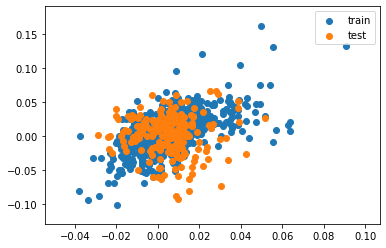

In [367]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions,test_targets,label='test')
plt.legend()
plt.show()